## Titanic Logistic Regression, Age Prediction
For the titanic exercise, I want to more closely link the ages to the passengers using a model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow  as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Normalization, Dropout, GaussianNoise, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [2]:
titles = {'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Don': 4, 'Rev': 5, 'Dr': 6, 'Mme': 7, 
          'Ms': 8, 'Major': 9, 'Lady': 10, 'Sir': 11, 'Mlle': 12, 'Col': 13, 'Capt': 14, 
          'the Countess': 15, 'Jonkheer': 16}

# Extract titles
data["Extracted_Title"] = data["Name"].apply(lambda name: name.split(",")[1].split(".")[0].strip())
data["Title"] = data["Extracted_Title"].map(titles)
data["Title"] = data["Title"].fillna(-1)

# Add Dummies
data = data.dropna(subset=['Age'])

data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# Confirm Updates
data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Extracted_Title,Title,Sex_male,Embarked_Q,Embarked_S,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,Mr,0,True,False,True,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,Mrs,1,False,False,False,2
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,Miss,2,False,False,True,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,Mrs,1,False,False,True,2
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,Mr,0,True,False,True,1


In [3]:
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S', "Title"]

# Assign Data Axis
X = data[features].values  
y = data['Age'].values.reshape(-1, 1)  

# Split Training Data (80% Training, 20% Validation)
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Parse data to correct NumPy types:
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)


# Define the model
model = Sequential([
    Dense(1024, activation='relu', input_shape=(len(features),)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu', input_shape=(len(features),)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu', input_shape=(len(features),)),
    Dense(1)  
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=1500, batch_size=128, validation_data=(X_val, y_val), verbose=False)


GPUs available: 2
Memory growth set for GPUs


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732018317.646224      68 service.cc:145] XLA service 0x7c08e8013e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732018317.646277      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732018317.646281      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732018321.636403      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# Save PassengerId for the final output AFTER all modifications to test_data
test_data = test_data.dropna(subset=['Age'])  # Drop rows with missing Age
passenger_ids = test_data['PassengerId']  # Update PassengerId to match filtered data

test_data["Extracted_Title"] = test_data["Name"].apply(lambda name: name.split(",")[1].split(".")[0].strip())
test_data["Title"] = test_data["Extracted_Title"].map(titles)
test_data["Title"] = test_data["Title"].fillna(-1)

# Add FamilySize
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'], drop_first=True)

# Ensure all selected features are available in test_data
X_test = test_data[features].values
X_test = X_test.astype('float32')

In [6]:

# Make predictions
predictions = model.predict(X_test)
rounded_predictions = tf.round(predictions * 2) / 2

# Create output DataFrame for predictions with PassengerId and predicted Age
output_df = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Age": predictions.flatten()  # Flatten to ensure the correct shape
})

# Save predictions to CSV
output_df.to_csv("submission.csv", index=False)
model.save('prediction_model.keras')

output_df['Age'] = output_df['Age'].fillna(0).apply(lambda x: round(x * 2) / 2)
output_df.head()



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


,PassengerId,Age
0,892,42.5
1,893,38.5
2,894,37.5
3,895,28.0
4,896,28.0


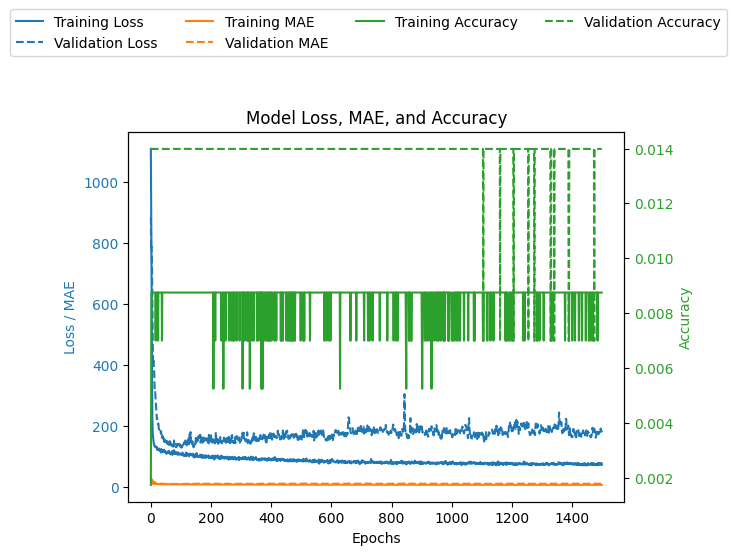

In [7]:
fig, ax1 = plt.subplots()

# Plot Loss on the primary y-axis
ax1.plot(history.history['loss'], label='Training Loss', color='tab:blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='tab:blue', linestyle="--")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss / MAE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot MAE on the primary y-axis
ax1.plot(history.history['mae'], label='Training MAE', color='tab:orange')
ax1.plot(history.history['val_mae'], label='Validation MAE', color='tab:orange', linestyle="--")

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='tab:green')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:green', linestyle="--")
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add legends for clarity
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.title("Model Loss, MAE, and Accuracy")
plt.show()